# 0. Организационное про домашнюю работу

- Сдаем в энитаске. Говорят, вы знаете, что делать со следующей инфой:
    - https://anytask.org/course/1069
    - Anytask: NLSAbHd
- Дедлайн **02.12.2023** в 23.30 (так настроен энитаск сейчас) 
- Пожалуйста, в названии файла укажите префикс задания и свою фамилию и инициалы: **demand_tevanyan_ea**
- Цель задания - практика по мотивам занятия "Прогноз спроса".
- На задания нет правильных и неправильных ответов. Хочется посмотреть на полноту решения и продуманности с вашей стороны.
- В квадратных скобках указан вес каждого из пунктов. Необязательной является последняя, шестая часть. Бонусы в вашу карму.

- Данные:

    - (если пользуетесь): kaggle competitions download -c favorita-grocery-sales-forecasting
    - простое смертное скачивание: https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data

# 1. Задача

В наших руках оказались данные Эквадорского ритейлера с сотнями магазином и более чем 200000 товаров.
Мы довольно подробно обсудили на занятии, почему важно и нужно прогнозировать спрос, напомним основные тейки:

- Если мы привезли в магазин слишком мало товара, потребителем его не хватит.
- Если мы привезли в магазин слишком много товара, то возникают лишние расходы, связанные с хранением товаров, а также лишние расходы, связанные с просрочкой товаров.


Хотелось бы уметь избегать всех этих лишних расходов и привозить в каждый магазин ровно столько товара, сколько нужно.


## Цель
- сделать модель спроса на каждый товар

## NB
- датасет большой и непростой
- на это задание нет правильных и неправильных ответов
- важно обосновывать свои допущения в процессе решения

# 2. Данные

**Описания файлов и информация о данных**

**train.csv** <br>
- Обучающие данные, включающие значения целевой переменной <code>unit_sales</code> по дате, номеру магазина <code>(store_nbr)</code> и номеру товара <code>(item_nbr)</code>, а также уникальный идентификатор для маркировки строк.
- Целевая переменная <code>unit_sales </code> может быть целым числом (например, упаковка чипсов) или числом с плавающей запятой (например, 1,5 кг сыра). Отрицательные значения unit_sales представляют возвраты этого конкретного товара.
- Столбец <code>onpromotion</code> указывает, был ли товар <code>(item_nbr)</code> на продаже <code>(promotion)</code> на указанную дату и в указанном магазине. Приблизительно 16% значений onpromotion в этом файле равны NaN.
- ПРИМЕЧАНИЕ: В обучающих данных отсутствуют строки для товаров с нулевыми unit_sales для комбинации магазин/дата. Нет информации о том, был ли товар в наличии в магазине в указанную дату, и команды должны решить, как лучше всего обработать эту ситуацию. Кроме того, в обучающих данных есть небольшое количество товаров, которые не встречаются в тестовых данных (они отсутствуют).

**stores.csv**  <br>
Метаданные магазинов, включая город<code>city</code>, штат<code>state</code>, тип<code>type</code> и кластер <code>cluster</code>. Кластер - это группировка похожих магазинов.
 
**items.csv** <br>
Метаданные товаров, включая семейство (<code>family</code>), класс <code>class</code> и скоропортящиеся товары (<code>perishable</code>). ПРИМЕЧАНИЕ: Товары, помеченные как perishable, имеют весовой коэффициент 1.25; в противном случае вес равен 1.0.

**transactions.csv** <br>
Количество транзакций продаж для каждой даты и комбинации магазин/номер товара. Включено только для временного интервала обучающих данных.

**oil.csv**  <br>
Ежедневные цены на нефть.(Эквадор - страна, зависящая от нефти, и ее экономическое здоровье чрезвычайно уязвимо для колебаний цен на нефть.)

**holidays_events.csv** <br>
Праздники и события с метаданными.

- Особое внимание уделяйте столбцу <code>transferred</code>. Праздник, который официально выпадает на этот календарный день, но был перемещен на другую дату правительством. Перемещенный день больше похож на обычный день, чем на праздник. Чтобы найти день, когда он был на самом деле отмечен, поищите соответствующую строку, где тип - Transfer. Например, праздник Independencia de Guayaquil был перемещен с 09.10.2012 на 12.10.2012, что означает, что он был отмечен 12.10.2012. Дни с типом Bridge - это дополнительные дни, добавляемые к празднику (например, для продления выходных на длинные выходные). Их часто компенсирует день типа Work Day, который не является обычным рабочим днем (например, суббота), предназначенным для компенсации Bridge.
- <code>Additional </code>Дополнительные праздничные дни - это дни, добавленные к обычному календарному празднику, например, как обычно происходит вокруг Рождества (что делает канун Рождества праздником).


**Дополнительные заметки**  <br>
Заработная плата в общественном секторе выплачивается каждые две недели 15-го числа и в последний день месяца. Пр

# 3. Задания

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import warnings

warnings.filterwarnings('ignore')

## 3. 1. [40%] Target

В этой секции я предлагаю вам продумать, какой таргет вы хотите спрогнозировать:
- подневной / понедельный / ежемесячный
- для всех товаров, что есть в items, или на ограниченном наборе

Этот выбор должен быть обоснован анализом имеющихся данных. 
Идеи для проверки:
- сколько наблюдений есть на каждый из товаров
- есть ли товары, которые продаются редко
- есть ли товары, выведенные из ассортимента (отсутствие продаж в течение долго времени)

Высокая оценка за этот пункт - полнота и глубина вашего ответа.

In [4]:
# constants

DATE = 'date'

ITEM = 'item_nbr'

STORE = 'store_nbr'

TARGET = 'unit_sales'

PROMO = 'onpromotion'

PREDICTING_UNIT = 'unit_id'

HORIZONT = 7

In [5]:
data = pd.read_csv('train.csv')

/var/folders/9z/qk2z_2yx52x3vny8hmx1wj2c0000gp/T/ipykernel_42287/2815211952.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('train.csv')


In [9]:
data.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [23]:
# delete id column

data = data.drop('id', axis=1)

In [24]:
data.dtypes

date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
dtype: object

In [26]:
# decrease dtypes
data[data.columns[data.dtypes == int]] = data[data.columns[data.dtypes == int]].astype('int32')
data[data.columns[data.dtypes == float]] = data[data.columns[data.dtypes == float]].astype('float32')

# date -> datetime
data[DATE] = pd.to_datetime(data[DATE])

In [ ]:
# save dtypes decreased data

if not os.path.exists('data'):
    os.mkdir('data')

data.to_parquet('data/train.parquet', index=False)

In [35]:
data = pd.read_parquet('data/train.parquet')

In [95]:
data.groupby([ITEM, STORE, DATE]).size().unique()

array([1])

- на каждую дату приходится одно значение по каждому товару

### Target Analysis

In [36]:
data[TARGET].describe(percentiles=(i/10 for i in range(10)))

count    1.254970e+08
mean     8.554887e+00
std      2.301254e+01
min     -1.537200e+04
0%      -1.537200e+04
10%      1.000000e+00
20%      2.000000e+00
30%      2.000000e+00
40%      3.000000e+00
50%      4.000000e+00
60%      5.000000e+00
70%      7.000000e+00
80%      1.100000e+01
90%      1.800000e+01
max      8.944000e+04
Name: unit_sales, dtype: float64

- есть отрицательные значения, дропнем их

In [37]:
data = data[data[TARGET] >= 0]

In [38]:
data[TARGET].isna().mean()

0.0

- пропусков нет

### Date

In [39]:
data['date'].min(), data['date'].max(), data['date'].nunique()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'), 1684)

- история с января 2013 по авгест 2017 в ежедневном разрезе

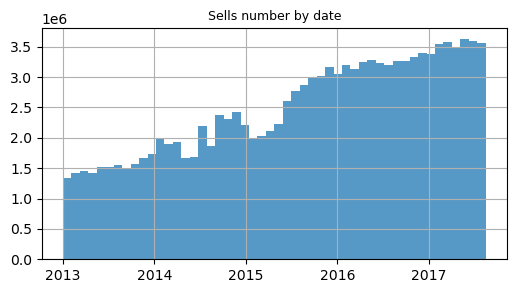

In [40]:
data[DATE].hist(alpha=0.75, bins=50, figsize=(6, 3))

plt.title('Sells number by date', fontsize=(9))
plt.show()

- число продаж выросло более чем в 2 раза за 4 года

### item_nbr, store_nbr

In [41]:
data[ITEM].nunique(), data[STORE].nunique()

(4036, 54)

- более 4000 товаров
- 54 магазина

In [42]:
data[[ITEM, STORE]].drop_duplicates().shape

(174682, 2)

- более 174к комбинаций товар+магазин

In [43]:
data[PREDICTING_UNIT] = data[ITEM].astype(str) + '_' + data[STORE].astype(str)

### Частота продаж

- посчитаем для каждого item-store частоту продаж, чтобы определиться с гранулярность

In [44]:
# sort data by unit, store, date

data = data.sort_values(by=[PREDICTING_UNIT, DATE])

In [45]:
# previous sell column

data['previous_sell'] = data.groupby([PREDICTING_UNIT])[DATE].shift(1)
data['date_delta'] = (data[DATE] - data['previous_sell']).dt.days

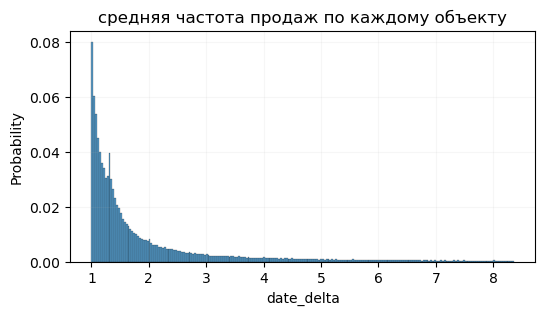

In [50]:
frequency = data.groupby([PREDICTING_UNIT])['date_delta'].mean()

plt.figure(figsize=(6, 3))

sns.histplot(
    frequency[frequency < frequency.quantile(0.95)], 
    stat='probability', 
    alpha=0.75
    )

plt.title('средняя частота продаж по каждому объекту')
plt.grid(alpha=0.1)
plt.show()

- большинство товаров продается не реже чем раз в 2 дня, эти товары и оставим для прогноза
-
- **Дополнение**: в реальной задаче можно дополнительно посчитать дисперсию частоты продаж и оставить товары и с большей частотой продаж чем 2, при условии низкой дисперсии (продаются редко, но с одинаковой частотой), но с **разрешения преподавателя**, проведем более агрессивный отбор товаров, чтобы уменьшить выборку и не тратить чрезмерное время на обучение моделей

### Доля дат с наличием продаж

- посчитаем для каждого item-store в какой доле дат истории присутсвуют продажи, оставим те, у которых это значие > 0.9
- 
- конечно, короткую историю могут иметь НОВИНКИ, которые так же важно спрогнозировать в жизни, но по причинам упомянутым в предыдущем пункте, делаем агрессивный отбор

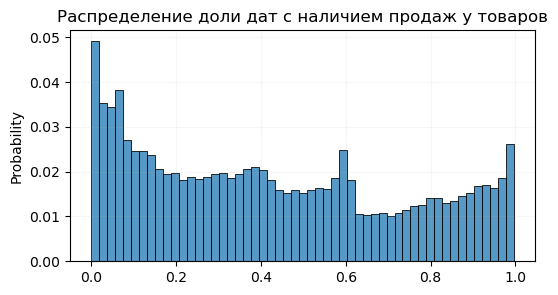

In [46]:
items_precense_prop = data.groupby([PREDICTING_UNIT]).size() / data[DATE].nunique()

plt.figure(figsize=(6, 3))

sns.histplot(
    items_precense_prop, 
    stat='probability', 
    alpha=0.75
    )

plt.title('Распределение доли дат с наличием продаж у товаров')
plt.grid(alpha=0.1)
plt.show()

In [47]:
(items_precense_prop > 0.9).mean()

0.09745709346126104

- 9% товаров имеют продажи более чем в 90% дат

### Более неактивные товары

- отсеем item-store, которые не продаются последнии 3 месяца

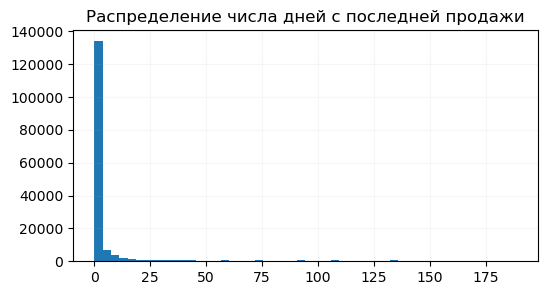

In [48]:
max_date = data[DATE].max()

last_sell = data.groupby([PREDICTING_UNIT])[DATE].max()

last_sell_diff = (max_date - last_sell).dt.days

plt.figure(figsize=(6, 3))

last_sell_diff[last_sell_diff < last_sell_diff.quantile(0.95)].hist(bins=50)

plt.title('Распределение числа дней с последней продажи')
plt.grid(alpha=0.1)
plt.show()

- у большинства товаров последняя продажа произошла менее 25 дней назад

### Фильтрация

In [51]:
# частота 
good_frequency = frequency[frequency <= 2].index

# history prop
good_history = items_precense_prop[items_precense_prop > 0.9].index

# active units
active = last_sell_diff[last_sell_diff < 91].index

keep_units = list(set(good_frequency) & set(good_history) & set(active))

print(len(keep_units))

16944


In [52]:
train = data[data[PREDICTING_UNIT].isin(keep_units)].reset_index(drop=True)

In [53]:
train.shape

(27204943, 8)

In [55]:
train.to_parquet('data/train__selected.parquet', index=False)

In [3]:
train = pd.read_parquet('data/train__selected.parquet')

In [54]:
del data
gc.collect()

11659

### Выводы:

1. **Гранулярность**: так как большинство товаров продается в среднем с частотой не менее 1 раза в 2 дня, то будем прогнозировать с дневной гранулярностью.
2. **Прогнозируемые объекты**: отбираем товары со стабильной историей продаж: 
    - продажи не реже 1 раза в 2 дня;
    - история продаж заполнена хотя бы на 90%;
    - товар активен (есть продажи в последние 91 день)

## 3. 2. [25%] Сбор датасета

- Определившись с таргетом, соберите свой тренировочный датасет. <br> Опишите, что вы в него решили включить.

- Здесь же продложу проделать:
    - EDA
    - Feature Engineering

## 3.2.0 EDA

In [21]:
AGG_LEVEL = 'D'

Если в какую-то дату не было продаж, эта дата не включается в датасет, поэтому включим их в датасет и заполним нулями.

In [56]:
train = train.sort_values(by=[PREDICTING_UNIT, DATE])

In [23]:
train_full = train.groupby([PREDICTING_UNIT, ITEM, STORE, DATE])[TARGET].sum().unstack(fill_value=0)\
        .stack().reset_index().rename(columns={0: TARGET})

In [24]:
train_full.shape

(28533696, 5)

In [25]:
# save aggregated data

train_full.to_parquet('data/train__aggregated.parquet', index=False)

In [4]:
train_full = pd.read_parquet('data/train__aggregated.parquet')

### Read all data

In [52]:
holidays = pd.read_csv('holidays_events.csv')

items = pd.read_csv('items.csv')

oil = pd.read_csv('oil.csv')

stores = pd.read_csv('stores.csv')

transactions = pd.read_csv('transactions.csv')

### Holidays

In [53]:
holidays.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

In [54]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [55]:
holidays['is_holiday'] = 1

In [56]:
holidays['transferred'].mean()

0.03428571428571429

In [57]:
holidays = holidays[~holidays['transferred']]

- только 3% праздников перенесли, поэтому раз они не состоялись, дропнем эти даты

In [58]:
# date -> datetime

holidays[DATE] = pd.to_datetime(holidays[DATE])
holidays['year'] = holidays[DATE].dt.year

Сагрегируем праздники в число праздников на дату в регионе

In [59]:
holidays = holidays.groupby(['locale_name', DATE, 'year'])['is_holiday'].sum().reset_index()

In [35]:
train_full = train_full.merge(holidays[[DATE, 'is_holiday']], how='left')
train_full['is_holiday'] = train_full['is_holiday'].fillna(0)

In [36]:
train_full.groupby('is_holiday')[TARGET].describe(percentiles=[i/10 for i in range(10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_holiday,,,,,,,,,,,,,,,
0.0,24416304.0,13.110466,22.317139,0.0,0.0,2.0000,3.0,5.0,6.0,8.0,10.0,13.0,18.0,28.0,14483.0
1.0,4456272.0,13.983053,31.714262,0.0,0.0,2.0000,3.0,5.0,6.0,8.0,10.0,14.0,19.0,30.0,20748.0
2.0,84720.0,16.490797,26.978607,0.0,0.0,2.6079,4.0,6.0,8.0,10.0,13.0,16.0,22.0,35.0,3040.0


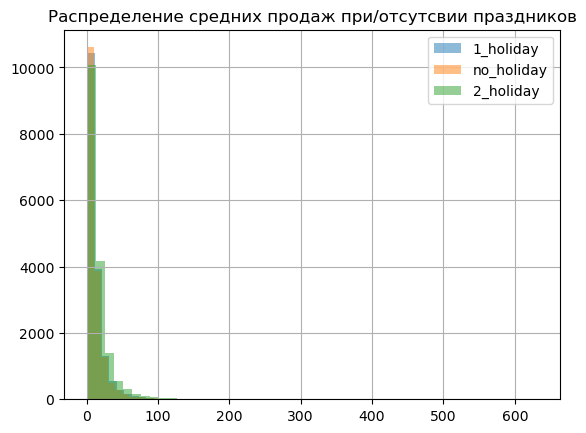

In [62]:
train_full[train_full['is_holiday'] == 1].groupby(PREDICTING_UNIT)[TARGET].mean().hist(alpha=0.5, label='1_holiday', bins=50)
train_full[train_full['is_holiday'] == 0].groupby(PREDICTING_UNIT)[TARGET].mean().hist(alpha=0.5, label='no_holiday', bins=50)
train_full[train_full['is_holiday'] == 2].groupby(PREDICTING_UNIT)[TARGET].mean().hist(alpha=0.5, label='2_holiday', bins=50)

plt.title('Распределение средних продаж при/отсутсвии праздников')
plt.legend()
plt.show()

- распределение средних продаж при 1 празднике/отсуствии празников идентично
- при числе праздников == 2, средние продажи выше

### Items

In [13]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [14]:
train_full = train_full.merge(items[[ITEM, 'family', 'class']], how='left')

In [15]:
# family

train_full.groupby('family')[TARGET].describe(percentiles=[i/10 for i in range(10)]).sort_values(by='50%')

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
family,,,,,,,,,,,,,,,
DELI,1525704.0,7.806320,8.213869,0.0,0.0,1.000,2.000,3.000,4.000,5.9470,7.000000,9.000,11.000000,17.000000,213.0
CLEANING,4407028.0,9.653519,17.534309,0.0,0.0,1.000,3.000,4.000,5.000,7.0000,8.000000,10.000,14.000000,20.000000,10685.0
DAIRY,2069636.0,10.596654,11.378978,0.0,0.0,2.000,3.000,5.000,6.000,7.0000,9.000000,12.000,16.000000,23.000000,2531.0
PERSONAL CARE,804952.0,11.063697,16.291056,0.0,0.0,1.000,3.000,4.000,6.000,7.0000,9.000000,12.000,16.000000,23.000000,3000.0
MEATS,1350568.0,16.514807,32.146938,0.0,0.0,1.634,3.090,4.446,5.995,7.8990,10.493000,14.363,21.077999,37.115152,11533.0
BREAD/BAKERY,1747992.0,13.130129,15.662672,0.0,0.0,2.000,4.000,5.000,7.000,8.0000,11.000000,14.000,19.000000,29.000000,2200.0
EGGS,793164.0,11.580756,11.725243,0.0,0.0,2.000,4.000,5.000,7.000,8.0000,10.000000,13.000,17.000000,25.000000,578.0
FROZEN FOODS,481624.0,12.308928,20.550127,0.0,0.0,2.000,3.000,5.000,6.000,8.0000,10.000000,12.000,17.000000,25.000000,2122.0
GROCERY I,12577796.0,13.029501,23.544910,0.0,0.0,2.000,3.000,5.000,6.000,8.0000,10.000000,13.000,18.000000,28.000000,20748.0


- POULTRY значительно опережает остальные категории по медиане и среднему продаж

In [16]:
# class 
train_full.groupby('class')[TARGET].describe(percentiles=[i/10 for i in range(10)]).sort_values(by='50%')

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
class,,,,,,,,,,,,,,,
4122,1684.0,3.589074,2.789041,0.0,0.0,1.000,1.000,2.0000,2.000,3.0000,4.000000,5.000000,6.000000,7.000000,20.000000
2690,57256.0,4.289709,4.498401,0.0,0.0,0.644,1.349,1.9290,2.502,3.1365,3.891000,4.868000,6.313000,8.971550,98.752998
2662,104408.0,4.522347,4.299037,0.0,0.0,0.770,1.388,1.9510,2.549,3.2500,4.130000,5.361000,7.102000,9.934300,88.332001
2664,47152.0,4.948483,4.541086,0.0,0.0,0.623,1.288,1.9963,2.804,3.7560,4.885600,6.204700,7.864800,10.804900,101.096001
1002,144824.0,5.995747,6.102669,0.0,0.0,1.000,2.000,3.0000,3.000,4.0000,5.000000,7.000000,9.000000,13.000000,95.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,6736.0,25.450119,22.990528,0.0,0.0,3.000,8.000,12.0000,15.000,19.0000,23.000000,29.000000,41.000000,57.000000,237.000000
2756,53888.0,24.526054,21.001835,0.0,0.0,5.000,9.000,12.0000,16.000,19.0000,23.000000,29.000000,38.000000,50.000000,526.000000
2246,50520.0,34.709145,52.537560,0.0,0.0,3.000,7.000,11.0000,15.000,20.0000,27.000000,36.000000,51.000000,78.000000,2122.000000


- ни один из классов сильно не выбивается по медиане продаж
- но по среднему продаж сильно выделяется класс: 2416, так как у него самые явные выбросы

### Stores

In [17]:
train_full = train_full.merge(stores)

In [18]:
train_full.head()

,unit_id,item_nbr,store_nbr,date,unit_sales,family,class,city,state,type,cluster
0,1003679_11,1003679,11,2013-01-01,0.0,GROCERY I,1028,Cayambe,Pichincha,B,6
1,1003679_11,1003679,11,2013-01-02,19.0,GROCERY I,1028,Cayambe,Pichincha,B,6
2,1003679_11,1003679,11,2013-01-03,12.0,GROCERY I,1028,Cayambe,Pichincha,B,6
3,1003679_11,1003679,11,2013-01-04,7.0,GROCERY I,1028,Cayambe,Pichincha,B,6
4,1003679_11,1003679,11,2013-01-05,18.0,GROCERY I,1028,Cayambe,Pichincha,B,6


In [19]:
# state

train_full.groupby('state')[TARGET].describe(percentiles=[i/10 for i in range(10)]).sort_values(by='50%')

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
state,,,,,,,,,,,,,,,
El Oro,1032292.0,10.486809,21.482439,0.0,0.0,1.000,3.000,4.0,5.0000,6.0,8.0,11.0,14.0,22.225800,8467.0
Santo Domingo de los Tsachilas,863892.0,9.820787,19.579857,0.0,0.0,1.000,3.000,4.0,5.0000,6.0,8.0,10.0,14.0,21.000000,10685.0
Azuay,1308468.0,10.595799,24.867498,0.0,0.0,1.959,3.000,4.0,5.0000,7.0,9.0,11.0,15.0,23.000000,10074.0
Bolivar,328380.0,13.968214,23.537264,0.0,0.0,1.000,3.000,4.0,6.0000,7.0,10.0,13.0,19.0,31.000000,2172.0
Cotopaxi,523724.0,12.309415,28.085340,0.0,0.0,1.000,3.000,4.0,5.0052,7.0,9.0,12.0,17.0,27.000000,11533.0
Imbabura,333432.0,10.723650,21.111773,0.0,0.0,1.000,3.000,4.0,5.0000,7.0,8.0,11.0,15.0,23.000000,3121.0
Loja,644972.0,9.989215,18.837410,0.0,0.0,1.000,3.000,4.0,5.0000,7.0,8.0,11.0,14.0,21.000000,6131.0
Los Rios,976720.0,11.169098,16.021938,0.0,0.0,1.000,3.000,4.0,5.0000,7.0,9.0,11.0,16.0,25.000000,2270.0
Manabi,286280.0,12.051243,22.850107,0.0,0.0,1.000,3.000,4.0,6.0000,7.0,9.0,12.0,17.0,27.000000,4910.0


- распределение продаж схоже среди всех штатов

In [20]:
# cluster

train_full.groupby('cluster')[TARGET].describe(percentiles=[i/10 for i in range(10)]).sort_values(by='50%')

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
cluster,,,,,,,,,,,,,,,
9,968300.0,8.954329,11.294011,0.0,0.0,1.0000,2.7350,4.000,5.0000,6.0000,7.0,9.000000,12.392200,19.0000,647.00
4,1712628.0,9.462241,16.874590,0.0,0.0,1.0000,3.0000,4.000,5.0000,6.0000,8.0,10.000000,13.000000,20.0000,8467.00
13,2172360.0,9.871247,20.027821,0.0,0.0,1.3660,3.0000,4.000,5.0000,6.0000,8.0,10.000000,13.905200,20.2180,10103.00
2,705596.0,10.115942,12.539926,0.0,0.0,2.0000,3.0000,4.000,5.0000,7.0000,9.0,11.000000,14.948000,22.0000,1786.00
3,2003960.0,10.996209,22.142818,0.0,0.0,1.0000,3.0000,4.000,5.0000,7.0000,9.0,11.000000,15.000000,24.0000,10685.00
15,1530756.0,11.827873,23.083189,0.0,0.0,1.0000,3.0000,4.000,5.0000,7.0000,9.0,12.000000,16.000000,26.0000,11533.00
12,562456.0,11.724531,19.919668,0.0,0.0,1.0000,3.0000,4.000,6.0000,7.0000,9.0,12.000000,16.000000,26.0000,5326.00
10,1668844.0,12.813735,24.200466,0.0,0.0,1.0000,3.0000,4.000,5.8950,7.0000,9.0,12.000000,17.248400,28.0000,12016.00
1,1071024.0,12.764374,20.722761,0.0,0.0,1.6693,3.0000,5.000,6.0000,8.0000,10.0,13.000000,17.525999,27.0000,2915.00


-  а вот среди кластеров различий больше, чем среди штатов

### oil

In [21]:
oil[DATE] = pd.to_datetime(oil[DATE])

In [22]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [23]:
oil_tmp = oil.dropna()

sum_sales = train_full[train_full[DATE].isin(oil_tmp[DATE])].groupby(DATE)[TARGET].sum()

oil_tmp = oil_tmp[oil_tmp[DATE].isin(sum_sales.index)]
sum_sales = sum_sales[sum_sales.index.isin(oil_tmp[DATE])]

len(oil_tmp), len(sum_sales)

(1163, 1163)

In [24]:
np.corrcoef(oil_tmp['dcoilwtico'].values, sum_sales.values)

array([[1.       , 0.1398753],
       [0.1398753, 1.       ]])

- взаимосвязь между ценами на нефть и продажами отсутсвует

### Transactions

- создадим фичу: изменение числа транзакций в магазинах дата к дате 

In [25]:
transactions[DATE] = pd.to_datetime(transactions[DATE])

In [26]:
transactions = transactions[transactions[STORE].isin(train_full[STORE])]

transactions = transactions.sort_values(by=[STORE, DATE])

In [27]:
transactions.head()

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520


In [28]:
transactions['transactions'].describe(), transactions.isna().mean()

(count    78281.000000
 mean      1730.557734
 std        978.357115
 min          5.000000
 25%       1074.000000
 50%       1425.000000
 75%       2150.000000
 max       8359.000000
 Name: transactions, dtype: float64,
 date            0.0
 store_nbr       0.0
 transactions    0.0
 dtype: float64)

- пропусков и отрицательных значений нет

In [29]:
transactions['transactions_change'] = transactions['transactions'] / transactions.groupby(STORE)['transactions'].shift()

In [30]:
transactions = transactions.drop(['transactions'], axis=1)
transactions

,date,store_nbr,transactions_change
1,2013-01-02,1,NaN
47,2013-01-03,1,0.868309
93,2013-01-04,1,1.016367
139,2013-01-05,1,0.809984
185,2013-01-06,1,0.344599
...,...,...,...
83271,2017-08-11,54,1.146269
83325,2017-08-12,54,1.175781
83379,2017-08-13,54,1.167220
83433,2017-08-14,54,0.776091


- позже померджим их к основному дф

### PROMO

In [31]:
train[PROMO].mean(), train[PROMO].isna().mean()

(0.06964746358609979, 0.26793395597263336)

- в 6% точек проводилось ПРОМО, в 26% точек пропуски в промо (заполним их False)

In [32]:
train[PROMO] = train[PROMO].fillna(0)
train[PROMO] = train[PROMO].replace({True: 1, False: 0})

In [33]:
train.groupby(PROMO)[TARGET].describe(percentiles=[i/10 for i in range(10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
onpromotion,,,,,,,,,,,,,,,
0,25817857.0,13.609580,22.519012,0.016,0.016,2.0,4.000,5.0,6.0,8.0,10.0,13.0,18.0,28.296,20748.0
1,1387086.0,19.230331,44.663639,0.072,0.072,3.0,4.818,6.0,8.0,10.0,13.0,18.0,25.0,40.000,11533.0


- распределение значений продаж при ПРОМО выше, чем без него

In [34]:
# откладываем промо

promo_data = train[[DATE, PREDICTING_UNIT, 'onpromotion']]

### Total sells trend

In [58]:
train_full['year'] = train_full[DATE].dt.year
train_full['month'] = train_full[DATE].dt.month

In [60]:
unique_holidays = holidays[[DATE, 'is_holiday']].drop_duplicates()
unique_holidays['is_holiday'] =  unique_holidays['is_holiday'].replace(0, np.nan)
unique_holidays = unique_holidays[unique_holidays[DATE].isin(train_full[DATE])]

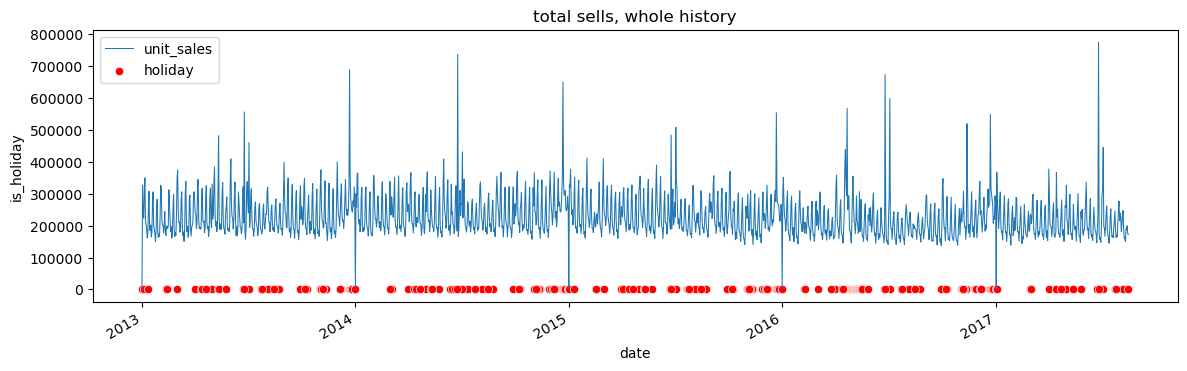

In [61]:
train_full.groupby(DATE)[TARGET].sum().plot(figsize=(14, 4), linewidth=0.75)

sns.scatterplot(x=unique_holidays[DATE], y=unique_holidays['is_holiday'], color='red', label='holiday')

plt.title('total sells, whole history')
plt.show()

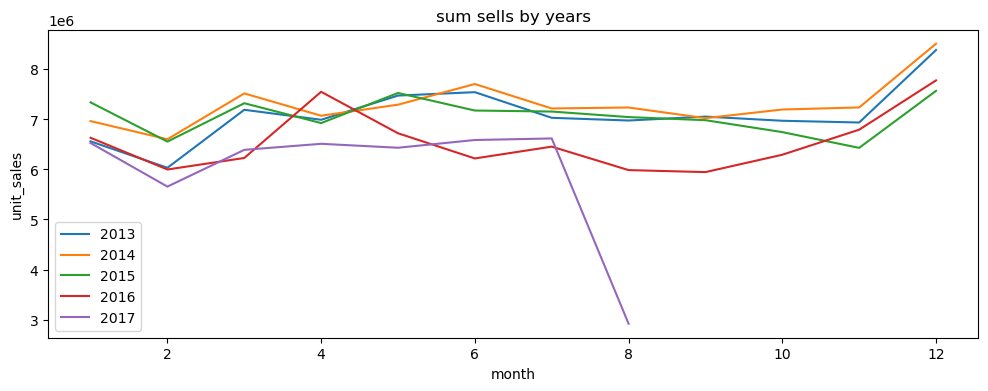

In [62]:
plt.figure(figsize=(12, 4))

for year in range(2013, 2018):
    tmp = train_full[train_full['year'] == year].groupby(['month'])[TARGET].sum()

    sns.lineplot(tmp, label=year)

plt.title('sum sells by years')
plt.show()

- 2016 & 2017 имеют более низкий уровень суммарных продаж

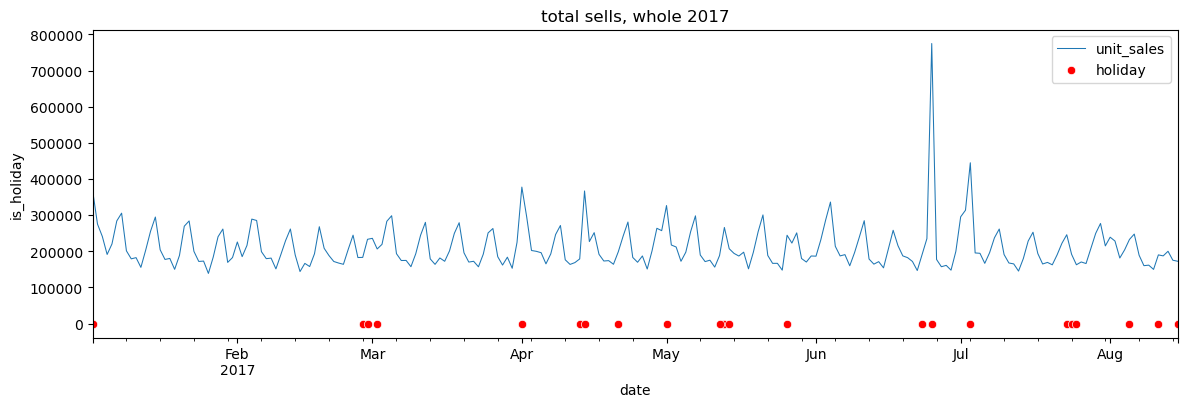

In [63]:
train_full[train_full[DATE] > '2017-01-01'].groupby(DATE)[TARGET].sum().plot(figsize=(14, 4), linewidth=0.75)

sns.scatterplot(x=unique_holidays[DATE], y=unique_holidays['is_holiday'], color='red', label='holiday')

plt.title('total sells, whole 2017')
plt.show()

- есть выбросы в суммарных продажах, которые в некоторых случаях выхваны праздниками, а в некоторых нет
- в каждом году резкий рост продаж в декабре, что вызвано рождеством и новогодними праздниками
- четкая недельная сезонность

## 3.2.1 Feature Engineering

In [5]:
import functions_feature_engineering
from joblib import Parallel, delayed

In [6]:
FEATURES_PATH = 'data/features'

if not os.path.exists(FEATURES_PATH):
    os.mkdir(FEATURES_PATH)

In [102]:
# продажи

sells_data = train_full[[PREDICTING_UNIT, DATE, TARGET]]

sells_data = sells_data.sort_values(by=[PREDICTING_UNIT, DATE])

In [39]:
# categorical data

cat_features = ['family', 'class', 'city', 'state', 'type', 'cluster']

### Cyclical features

- трансформируем sin/cos циклические признаки:
    - xsin = SIN((2 * pi * x) / max(x))
    - xcos = COS((2 * pi * x) / max(x))

In [ ]:
def transform_cyclical_features(data: pd.DataFrame, cyclical_features: list) -> pd.DataFrame:
    """
    Функция производит sin/cos преобразование циклических признаков.
    """
    available_features = ["dayofweek", "day", "dayofyear", "week", "month"]

    n_unique_values_map = {
        "dayofweek": 7,
        "day": 31,
        "dayofyear": 365,
        "week": 52,
        "month": 12
    }

    for feature in cyclical_features:
        assert np.isin(feature, available_features)
        
        data[f"{feature}_sin"] = np.sin((data[feature] * 2 * np.pi) / n_unique_values_map[feature])
        data[f"{feature}_cos"] = np.cos((data[feature] * 2 * np.pi) / n_unique_values_map[feature])
    
    return data


In [66]:
# create cyclical features

train_full['year'] = train_full[DATE].dt.year
train_full['month'] = train_full[DATE].dt.month
train_full['dayofweek'] = train_full[DATE].dt.day_of_week
train_full['day'] = train_full[DATE].dt.day
train_full['dayofyear'] = train_full[DATE].dt.day_of_year
train_full['week'] = train_full[DATE].dt.isocalendar().week

In [67]:
cyclycal_features = ['dayofweek', 'day', 'dayofyear', 'week', 'month']

cyclycal_data = train_full[[DATE] + cyclycal_features].drop_duplicates()

In [69]:
%%time

# transform cyclical features

cyclycal_data = transform_cyclical_features(
    data=cyclycal_data,
    cyclical_features=cyclycal_features
    )

CPU times: user 3.95 ms, sys: 1.52 ms, total: 5.48 ms
Wall time: 4.34 ms


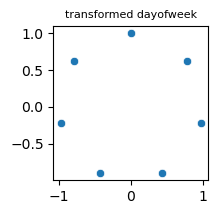

In [71]:
plt.figure(figsize=(2, 2))
sns.scatterplot(
    x=cyclycal_data['dayofweek_sin'].unique(), 
    y=cyclycal_data['dayofweek_cos'].unique()
)
plt.title('transformed dayofweek', fontsize=8)
plt.show()

### Rolling aggregations

- оконные агрегации

In [85]:
def create_roll_features(data: pd.DataFrame, target: str, gb_cols: list,  windows: list) -> pd.DataFrame:
    """
    Функция создает признаки аггрегации по целевой переменной в скользящем окне.

    :param data: pd.DataFrame с историей продаж
    :param target: str название целевой переменной
    :param gb_cols: list колонок для группировки
    :param windows: list размеров скользящего окна в зависимости от уровня аггрегации

    :return: pd.DataFrame с новыми признаками
    """
    # абсолютное изменение продаж
    data.loc[:, f'abs_change'] = data.groupby(gb_cols)[target].transform(
        lambda x: np.abs(x - x.shift())
    )

    for window in windows:
        for quantile in [0.1, 0.5, 0.9]:
            # квантили
            data.loc[:, f'{target}_roll_q{quantile}_w{window}'] = data.groupby(gb_cols)[target].transform(
                lambda x: x.rolling(window=window, min_periods=window).quantile(quantile)
                )
        # среднее counts
        data.loc[:, f'{target}_roll_mean_w{window}'] = data.groupby(gb_cols)[target].transform(
                lambda x: x.rolling(window=window, min_periods=window).mean()
                )
        # среднее не нулевых counts
        data.loc[:, f'non_zero_{target}_roll_mean_w{window}'] = data.groupby(gb_cols)[target].transform(
            lambda x: x.rolling(window=window, min_periods=window).apply(
                lambda y: y.replace(0, np.nan).mean()
            )
        )
        # std counts
        data.loc[:, f'{target}_roll_std_w{window}'] = data.groupby(gb_cols)[target].transform(
                lambda x: x.rolling(window=window, min_periods=window).std()
                )
        # сумма квадратов
        data.loc[:, f'{target}_roll_squared_sum_w{window}'] = data.groupby(gb_cols)[target].transform(
                lambda x: np.square(x).rolling(window=window, min_periods=window).sum()
                )
        # доля не нулей
        data.loc[:, f'{target}_roll_nonzero_prop_w{window}'] = data.groupby(gb_cols)[target].transform(
                lambda x: (x != 0).rolling(window=window, min_periods=window).mean()
                )
        # доля нулей
        data.loc[:, f'{target}_roll_zero_prop_w{window}'] = 1 - data.loc[:, f'{target}_roll_nonzero_prop_w{window}']
        
    
    return data

In [87]:
%%time

rolling_features = Parallel(n_jobs=3)(
    delayed(create_roll_features)(
        data=sells_data.copy(),
        target=TARGET,
        gb_cols=[PREDICTING_UNIT],
        windows=[w]
        )
        for w in [7, 14, 21]
        )

CPU times: user 4.79 s, sys: 14.1 s, total: 18.9 s
Wall time: 22min 47s


In [89]:
rolling_features_df = pd.concat(rolling_features, axis=1)
rolling_features_df = rolling_features_df.loc[:, ~rolling_features_df.columns.duplicated()].copy()

In [90]:
rolling_features_df.to_parquet(os.path.join(FEATURES_PATH, 'rolling_features__tmp.parquet'), index=False)

### Previous year locality

-  окрестность предыдущего года

In [107]:
def create_last_year_locality_features(data: pd.DataFrame, target: str, product_level: str, n: int, year_period: int) -> pd.DataFrame:
    """
    Функция считает значения продаж в окрестности предыдущего года.

    :param data: pd.DataFrame с историе продаж
    :param target: str название целевой переменной
    :param product_level: str уровень агрегации продукта
    :param sort_by_cols: list колонок для сортировки
    :param year_period: str число периодов одного года

    :return: pd.DataFrame с новыми признаками
    """
    # точки в окрестности прошлого года
    lags = range(year_period - n, year_period + n + 1)
    # считаем значения в окрестности прошлого года
    for lag in lags:
        data[f'{target}_y_ago_lag{lag}'] = data.groupby(product_level)[target].transform(
            lambda x: x.shift(lag)
            ).values
    
    return data

In [108]:
prev_year_locality = create_last_year_locality_features(
    data=sells_data.copy(),
    target=TARGET,
    product_level=PREDICTING_UNIT, 
    n=7, 
    year_period=365
)

In [110]:
prev_year_locality.to_parquet(os.path.join(FEATURES_PATH, 'prev_year_locality__tmp.parquet'), index=False)

### Lag features

- лаговые фичи, и соотношение lag_{i}/lag_{i+1}

In [111]:
def create_lag_features(
    data: pd.DataFrame, target: str, product_level:str,  min_lag: int, max_lag: int
    ) -> pd.DataFrame:
    """
    Функция считает лаг признаки в диапазоне min_lag - max_lag
    и значения y_{lag}/y_{lag+1}.

    :param data: pd.DataFrame с историей продаж
    :param target: str название колонки, по которой создаются признаки
    :param product_level: str уровень агрегации продукта
    :param min_lag: int значение минимального лага
    :param max_lag: int значение максимального лага

    :return: pd.DataFrame с новыми признаками
    """

    # считаем лаги
    for lag in range(min_lag, max_lag + 1):
        data[f'{target}_lag{lag}'] = data.groupby(product_level)[target].transform(
            lambda x: x.shift(lag)
        )

        if lag < max_lag:
            data[f'{target}_lag{lag}/lag{lag+1}'] = data.groupby(product_level)[target].transform(
                lambda x: x.shift(lag) / x.shift(lag+1)
            )
    
    # исправляем inf (вызванные x/0, где x > 0) и лишние NaN (вызванные 0/0)
    for lag in range(min_lag, max_lag):
        # если оба значения == 0, в {target}_lag{lag}/lag{lag+1} будет NaN, поэтому заполняем их единицей
        data.loc[(data[f'{target}_lag{lag}'] == 0) & 
                (data[f'{target}_lag{lag+1}'] == 0),
                 f'{target}_lag{lag}/lag{lag+1}'] = 1
        # если числитель > 0 и знаменатель == 0, в {target}_lag{lag}/lag{lag+1} inf меняем на 2 
        data.loc[(data[f'{target}_lag{lag}'] > 0) & 
                (data[f'{target}_lag{lag+1}'] == 0),
                 f'{target}_lag{lag}/lag{lag+1}'] = 2
    
    return data

In [112]:
lag_features = create_lag_features(
    data=sells_data.copy(),
    target=TARGET,
    product_level=PREDICTING_UNIT,
    min_lag=0, 
    max_lag=14
)

In [114]:
lag_features.to_parquet(os.path.join(FEATURES_PATH, 'lags__tmp.parquet'), index=False)

### Merge all features

In [42]:
train_full = train_full.sort_values(by=[PREDICTING_UNIT, DATE]).reset_index(drop=True)

In [43]:
sells_data = train_full.copy()

In [44]:
# lag features
lag_features = pd.read_parquet(os.path.join(FEATURES_PATH, 'lags__tmp.parquet'))

lag_features = lag_features.sort_values(by=[PREDICTING_UNIT, DATE]).reset_index(drop=True)

lag_features_columns = lag_features.columns[~lag_features.columns.isin(sells_data.columns)]

sells_data = pd.concat([sells_data.reset_index(drop=True), lag_features[lag_features_columns]], axis=1)

del lag_features
gc.collect()

0

In [45]:
# previous year locality 
prev_year_locality = pd.read_parquet(os.path.join(FEATURES_PATH, 'prev_year_locality__tmp.parquet'))

prev_year_locality = prev_year_locality.sort_values(by=[PREDICTING_UNIT, DATE]).reset_index(drop=True)

prev_year_locality_columns = prev_year_locality.columns[~prev_year_locality.columns.isin(sells_data.columns)]

sells_data = pd.concat([sells_data.reset_index(drop=True), prev_year_locality[prev_year_locality_columns]], axis=1)

del prev_year_locality
gc.collect()

0

In [47]:
# rollings
rolling_features_df = pd.read_parquet(os.path.join(FEATURES_PATH, 'rolling_features__tmp.parquet'))

rolling_features_df = rolling_features_df.sort_values(by=[PREDICTING_UNIT, DATE]).reset_index(drop=True)

rolling_features_df_columns = rolling_features_df.columns[~rolling_features_df.columns.isin(sells_data.columns)]

sells_data = pd.concat([sells_data.reset_index(drop=True), rolling_features_df[rolling_features_df_columns]], axis=1)

del rolling_features_df
gc.collect()

0

In [48]:
# promo

sells_data = sells_data.merge(promo_data, on=[DATE, PREDICTING_UNIT], how='left')
sells_data['onpromotion'] = sells_data['onpromotion'].fillna(0)

### Holidays

- последний сэт признаков нагенерим из праздников:
    - количество дней до ближайшего прошедшго/будущего праздника

In [ ]:
def calculate_nearest_holidays(
    date, holidays_data: pd.DataFrame, date_col: str, future=True
    ):
    """
    Функция счтает количество периодов до ближайшего праздника/нового года.

    :param date: pd.datetime дата
    :param holidays_data: pd.DataFrame с датами праздников в России
    :param date_col: str название колонки с датой в holidays_data
    :param future: bool - True(default) - до ближайшего праздника в будущем
                        - False - до ближайшего празднкика в прошлом
    
    :return: pd.Series с дистанциями до ближайшего праздника
    """

    # дней до всех праздников
    days_to_holiday = (date - holidays_data[date_col]).dt.days
    
    # периодов до ближайшего праздника
    periods_to_hol = np.min(np.abs(days_to_holiday[(days_to_holiday == 0) | (days_to_holiday < 0)]))
    if not future:
        periods_to_hol = np.min(np.abs(days_to_holiday[(days_to_holiday == 0) | (days_to_holiday > 0)]))

    return periods_to_hol


def create_holidays_features(
    data: pd.DataFrame, holidays_data: pd.DataFrame
    ):
    """
    Функция создает признаки на основе праздников:
        - дистанция до ближайшего праздника в будущем/в прошлом

    :param data: pd.DataFrame с истрией продаж
    :param holidays_data: pd.DataFrame с датами праздников в России

    :return: pd.DataFrame с новыми признаками holidays
    """
    # date -> pd.to_datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # отложим только уникальные даты
    unique_dates = data[['date']].drop_duplicates()
    
    # признаки до праздников
    unique_dates[f'd_to_holiday_future'] = unique_dates['date'].transform(
        lambda x: calculate_nearest_holidays(
            date=x, holidays_data=holidays_data, date_col='date'
            )
        )
    unique_dates[f'd_to_holiday_past'] = unique_dates['date'].transform(
        lambda x: calculate_nearest_holidays(
            date=x, holidays_data=holidays_data, date_col='date', future=False
            )
        )
    
    # date -> str
    unique_dates['date'] = unique_dates['date'].astype(str)
    data['date'] = data['date'].astype(str)

    # соединяем признаки к основном датафрейму
    data = data.merge(unique_dates, how='left')

    return data

In [64]:
all_features = create_holidays_features(
    data=sells_data.copy(),
    holidays_data=holidays,
)

In [67]:
all_features.shape

(28533696, 86)

In [69]:
all_features.to_parquet(os.path.join(FEATURES_PATH, 'data__features.parquet'), index=False)

In [70]:
# удалим временные файлы
tmp_files = [file for file in os.listdir(FEATURES_PATH) if 'tmp' in file]

for file in tmp_files:
    file_path = os.path.join(FEATURES_PATH, file)
    os.unlink(file_path)

## 3.2.2 Target

Создадим таргет: сдвинем значения сырого таргета на HORIZONT значений в прошлое.

Так как мы прогнозируем на 7 дней вперед, то каждому значению таргета должны соответсвовать признаки известные на 7 дней назад.

По хорошему, нужно генерировать отдельные таргеты для каждого значения из [1:HORIZONT] и обучать для каждого таргета отдельную модель, но для выполнения ДЗ огрначимся максимальным горизонтом, чтобы не ждать чрезмерно-большое время.

In [7]:
all_features = pd.read_parquet(os.path.join(FEATURES_PATH, 'data__features.parquet'))

In [10]:
for horizont in [HORIZONT]:
    if horizont < 10:
        all_features[f'target_0{horizont}'] = all_features.groupby([PREDICTING_UNIT])[TARGET].shift(-horizont)
    else:
        all_features[f'target_{horizont}'] = all_features.groupby([PREDICTING_UNIT])[TARGET].shift(-horizont)

## 3. 3. [25%] Training and Validation

На занятии мы обсуждали три пакета-реализации градиентного бустинга. Попробуйте применить любой из них с дефолтными параметрами ИЛИ любую удобную вам реализацию бустинга для обучения модели. Все детали обучения - на ваше усмотрение (функция ошибок, метрика качества).

Помните: модели, обученные на данных с временной структурой, не корректно валидировать k-fold-кросс-валидацией и обсудили две альтернативы. Не забудьте организовать корректные разбиения данных под будущее 

**Заметки**
- началом тестового периода будет 2016-08-15
- в качетсве кросс-валидации будем использовать TimeSeriesKFold
- все товары прогнозировать одной моделью некорректно, так как они могут иметь разные паттерны поведения, поэтому разобъем данные на группы по колонке **cluster**
- мерить качество будем с помощью ...

In [11]:
import logging
from tqdm import tqdm
import datetime
from catboost import CatBoostRegressor

In [12]:
PREDICTIONS_PATH = 'data/predictions'

if not os.path.exists(PREDICTIONS_PATH):
    os.mkdir(PREDICTIONS_PATH)

In [13]:
LOGS_PATH = os.path.join(PREDICTIONS_PATH, 'logging_predictions.log')

### Constants

In [14]:
# modeling constants

RANDOM_SEED = 42

TEST_START = '2016-08-15'

CAT_FEATURES = ['family', 'class', 'city', 'state', 'type']

DROP_FEATURES = [PREDICTING_UNIT, STORE, ITEM, DATE, TARGET, 'cluster']

GROUPPING_COL = 'cluster'

TARGETS = [col for col in all_features.columns if 'target' in col]

FEATURES = list(all_features.loc[:,~all_features.columns.isin(TARGETS + DROP_FEATURES)].columns)

In [15]:
len(FEATURES)

80

### Time Series KFold

- разобъем последний год на 4 равные части и будем их поочередно использовать в качестве тестового периода, включая предыдущую в тренировочный период

In [16]:
# даты тестового периода

test_dates = all_features[all_features[DATE] >= TEST_START][DATE].unique()
test_dates = pd.DataFrame({DATE: test_dates})

# создаем группы равные горизонту прогнозирования
test_dates['test_group'] = test_dates[DATE].index // 92

In [17]:
test_dates['test_group'].value_counts()

test_group
0    92
1    92
2    92
3    89
Name: count, dtype: int64

In [101]:
all_features[[PREDICTING_UNIT, 'cluster']].groupby('cluster')[PREDICTING_UNIT].nunique()

cluster
1      636
2      419
3     1190
4     1017
5      890
6     1579
7      112
8     1942
9      575
10     991
11    1620
12     334
13    1290
14    2787
15     909
16      68
17     585
Name: unit_id, dtype: int64

### Catboost

In [131]:
params = {
    'iterations': 500,
    'best_model_min_trees': 20,
    'verbose': 0,
    'random_state': RANDOM_SEED,
    'loss_function': 'RMSE',
    'max_depth': 4,
    'task_type': 'CPU',
    'cat_features': CAT_FEATURES
}

In [134]:
# инициализируем логирование
logging.basicConfig(level=logging.INFO, filename=LOGS_PATH, filemode="w")

all_predictions = []

for group in tqdm(all_features[GROUPPING_COL].unique()):
    for target in TARGETS:
        horizont = target.split('_')[-1]

        # Делаем copy т.к. потом ещё shift зависящий от таргета и dropna
        predicting_data = all_features[all_features[GROUPPING_COL] == group].copy()

        # drop строк где текущий таргет NaN
        predicting_data.dropna(subset=[target], inplace=True)

        # откладываем тестовый период, к которому прикрепим прогнозы
        test_data = predicting_data[
            predicting_data[DATE].isin(test_dates[DATE].unique())
        ][[PREDICTING_UNIT, DATE] + [TARGET] + [target]]

        # массив для хранения прогнозов
        predictions = []

        # start rolling prediction
        for idx, test_group in enumerate(test_dates['test_group'].unique()):
            # нынешняя тестовая группа
            current_test_group = test_dates[test_dates['test_group'] == test_group][DATE].unique()
            # начало нынешней тестовой группы
            start_of_current_test_group = current_test_group.min()

            # init model
            model = CatBoostRegressor(**params)

            # начало тренировочного периода (6 месяцев назад)
            train_start = pd.to_datetime(start_of_current_test_group) - pd.DateOffset(days=182)

            # train/test split
            train = predicting_data.loc[
                (predicting_data[DATE] < start_of_current_test_group) &
                (predicting_data[DATE] >= str(train_start)),
                FEATURES]
            test = predicting_data.loc[predicting_data[DATE].isin(current_test_group), FEATURES]

            y_train = predicting_data.loc[
                (predicting_data[DATE] < start_of_current_test_group) &
                (predicting_data[DATE] >= str(train_start)),
                target]
            
            model.fit(train, y_train)
            prediction = model.predict(test)

            pred_df = pd.concat([
                predicting_data.loc[predicting_data[DATE].isin(current_test_group), [DATE, GROUPPING_COL]].reset_index(drop=True),
                predicting_data.loc[predicting_data[DATE].isin(current_test_group), PREDICTING_UNIT].reset_index(drop=True),
                pd.DataFrame(prediction, columns=['prediction'])
            ], axis=1)
            pred_df['horizont'] = horizont

            predictions.append(pred_df)

        # соединяем rolling прогнозы
        group_preds = pd.concat(predictions)

        test_data = test_data.merge(
            group_preds, 
            on=[DATE, PREDICTING_UNIT]
        )

        # добавляем к дате число периодов равное горизонту прогноза
        test_data[DATE] = pd.to_datetime(test_data[DATE]) + pd.DateOffset(days=7) 
        # model name
        test_data['model'] = f'CB'
        
        # добывляем прогнозы в список всех прогнозов
        all_predictions.append(test_data)

        now = datetime.datetime.now()

        logging.info(
            f"{now} group_{group}, horizont_{horizont} is DONE"
            )
        
all_preds = pd.concat(all_predictions)

all_preds.to_parquet(os.path.join(PREDICTIONS_PATH, f'predictions.parquet'), index=False)

100%|██████████| 17/17 [09:23<00:00, 33.18s/it]


### Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor

- закодируем категориальные признаки используя CatBoostEncoder
- для кодировки обучимся только на тренировочных данных

In [32]:
# train set for catboost encoder

train = all_features[all_features[DATE] < TEST_START]

In [18]:
all_features[CAT_FEATURES].nunique()

family     14
class     131
city       20
state      15
type        5
dtype: int64

In [ ]:
!pip install category_encoders

In [20]:
import category_encoders as ce

In [33]:
encoder = ce.CatBoostEncoder()

# fit 
encoder.fit(train[FEATURES], train[TARGET], cols=CAT_FEATURES)

CatBoostEncoder(cols=['family', 'city', 'state', 'type'])

In [35]:
# transform

all_features[FEATURES] = encoder.transform(all_features[FEATURES], all_features[TARGET])

#### RF Training

In [45]:
params_rf = {
    'n_estimators': 100,
    'max_depth': 4,
    'random_state': RANDOM_SEED
}

In [38]:
# exp = all_features[(all_features['cluster'] == 16) & (all_features[DATE] >= '2016-01-01')]

In [49]:
# запонлним пропуски значением, которое не встречается во всей выборке

all_features[FEATURES] = all_features[FEATURES].fillna(-999)

In [50]:
# инициализируем логирование
logging.basicConfig(level=logging.INFO, filename=LOGS_PATH, filemode="w")

all_predictions = []

for group in tqdm(all_features[GROUPPING_COL].unique()):
    for target in TARGETS:
        horizont = target.split('_')[-1]

        # Делаем copy т.к. потом ещё shift зависящий от таргета и dropna
        predicting_data = all_features[all_features[GROUPPING_COL] == group].copy()

        # drop строк где текущий таргет NaN
        predicting_data.dropna(subset=[target], inplace=True)

        # откладываем тестовый период, к которому прикрепим прогнозы
        test_data = predicting_data[
            predicting_data[DATE].isin(test_dates[DATE].unique())
        ][[PREDICTING_UNIT, DATE] + [TARGET] + [target]]

        # массив для хранения прогнозов
        predictions = []

        # start rolling prediction
        for idx, test_group in enumerate(test_dates['test_group'].unique()):
            # нынешняя тестовая группа
            current_test_group = test_dates[test_dates['test_group'] == test_group][DATE].unique()
            # начало нынешней тестовой группы
            start_of_current_test_group = current_test_group.min()

            # init model
            model = RandomForestRegressor(**params_rf)

            # начало тренировочного периода (6 месяцев назад)
            train_start = pd.to_datetime(start_of_current_test_group) - pd.DateOffset(days=182)

            # train/test split
            train = predicting_data.loc[
                (predicting_data[DATE] < start_of_current_test_group) &
                (predicting_data[DATE] >= str(train_start)),
                FEATURES]
            test = predicting_data.loc[predicting_data[DATE].isin(current_test_group), FEATURES]

            y_train = predicting_data.loc[
                (predicting_data[DATE] < start_of_current_test_group) &
                (predicting_data[DATE] >= str(train_start)),
                target]
            
            model.fit(train, y_train)
            prediction = model.predict(test)

            pred_df = pd.concat([
                predicting_data.loc[predicting_data[DATE].isin(current_test_group), [DATE, GROUPPING_COL]].reset_index(drop=True),
                predicting_data.loc[predicting_data[DATE].isin(current_test_group), PREDICTING_UNIT].reset_index(drop=True),
                pd.DataFrame(prediction, columns=['prediction'])
            ], axis=1)
            pred_df['horizont'] = horizont

            predictions.append(pred_df)

        # соединяем rolling прогнозы
        group_preds = pd.concat(predictions)

        test_data = test_data.merge(
            group_preds, 
            on=[DATE, PREDICTING_UNIT]
        )

        # добавляем к дате число периодов равное горизонту прогноза
        test_data[DATE] = pd.to_datetime(test_data[DATE]) + pd.DateOffset(days=7) 
        # model name
        test_data['model'] = f'RF'
        
        # добывляем прогнозы в список всех прогнозов
        all_predictions.append(test_data)

        now = datetime.datetime.now()

        logging.info(
            f"{now} group_{group}, horizont_{horizont} is DONE"
            )
        
all_preds = pd.concat(all_predictions)

all_preds.to_parquet(os.path.join(PREDICTIONS_PATH, f'predictions__rf.parquet'), index=False)

100%|██████████| 17/17 [2:32:01<00:00, 536.58s/it]  


## 3. 4.  [10%] Discussion

Что получилось? Какого качества модель? Довольны ли вы результатами? Сравните качество, например, со случайным лесом на 100 деревьях. Что лучше-хуже? 

### Read predictions

In [52]:
TARGET = 'target_07'

PREDICTION = 'prediction'

PREDICTIONS_PATH = 'data/predictions'

In [53]:
# read predictions
cb = pd.read_parquet(os.path.join(PREDICTIONS_PATH, 'predictions.parquet'))
rf = pd.read_parquet(os.path.join(PREDICTIONS_PATH, 'predictions__rf.parquet'))
rf['model'] = 'RF'

# concat predictions
all_preds = pd.concat([cb, rf])

In [54]:
all_preds.shape

(12131904, 8)

### Postprocessing
- округляем прогнозы
- зануляем отрицательные прогнозы

In [56]:
all_preds.loc[all_preds[PREDICTION] < 0, PREDICTION] = 0

all_preds[PREDICTION] = np.abs(np.round(all_preds[PREDICTION]))

In [57]:
# add month 

all_preds['month'] = all_preds[DATE].dt.month

### Metrics

В качестве метрик будем использовать:
- MedianAPE
- WAPE

Слабостью MedianAPE является то, что на товарах которые продаются в маленьких значениях, любое отклонение будет давать большую % ошибку, поэтому дополнительно используем WAPE, которые невелирует эти ошибки, так как товары с высокими продажами будут вносить больший вес в метрику.

In [58]:
def wape(actual, forecast):
    assert len(actual) == len(forecast)
    
    err = np.sum(np.abs(actual - forecast)) / np.sum(actual)

    return err

In [59]:
# abs % error
all_preds['perc_error'] = np.abs(all_preds[TARGET] - all_preds[PREDICTION]) / all_preds[TARGET]

# 0/0 = nan => nan -> 0
all_preds.loc[all_preds['perc_error'].isna(), 'perc_error'] = 0

# n/0 = inf => inf -> 1(100%)
all_preds.loc[all_preds['perc_error'].eq(np.inf), 'perc_error'] = 1

### Распределение abs % error

In [60]:
all_preds.groupby('model')['perc_error'].describe(percentiles=[i/10 for i in range(10)])

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
model,,,,,,,,,,,,,,,
CB,6065952.0,0.799537,2.322736,0.0,0.0,0.054054,0.151515,0.230769,0.318182,0.400000,0.500000,0.666667,1.0,1.75,962.0
RF,6065952.0,0.848410,1.920467,0.0,0.0,0.066667,0.166667,0.250000,0.333333,0.411765,0.533333,0.714286,1.0,2.00,695.5


- МАPE catboost имеет на 5% меньше
- а вот MedianAPE на одном уровне (~1% преимущество catboost)
- средняя ошибка высокая из-за выбросов, поэтому ориентироваться на MAPE не всегда правильное решение

### Визуализация

#### WAPE

In [61]:
all_preds.groupby('model').apply(
    lambda x: wape(x[TARGET], x[PREDICTION])
)

model
CB    0.473647
RF    0.483538
dtype: float64

In [62]:
wape_metric = all_preds.groupby(['month', 'model']).apply(
    lambda x: wape(x[TARGET], x[PREDICTION])
).reset_index().rename(columns={0: 'wape'})

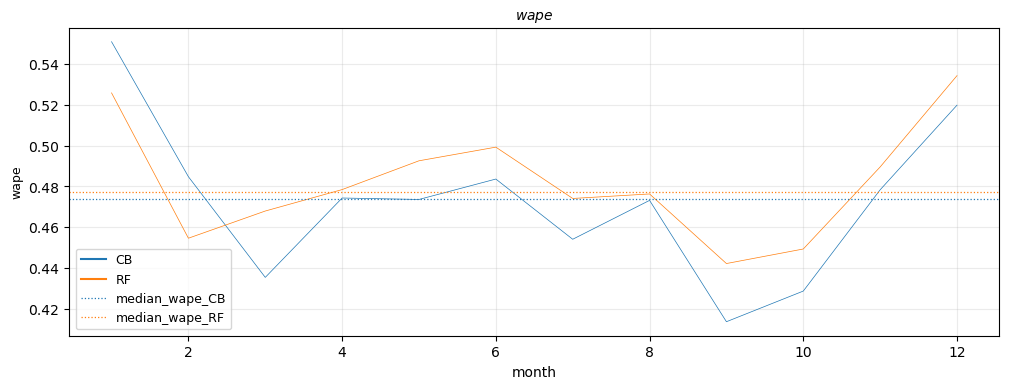

In [63]:
 # визуализация
metric_name = 'wape'

fig = plt.figure(figsize=(12, 4))

sns.lineplot(
            x=wape_metric['month'],
            y=wape_metric[metric_name],
            hue=(wape_metric['model']).astype(str),
            linewidth=0.5
        )

for model, color in zip(['CB', 'RF'], ['tab:blue', 'tab:orange']):
    plt.axhline(
            wape_metric[wape_metric['model'] == model][metric_name].median(),
            color=color, label=f'median_{metric_name}_{model}', linestyle='dotted', linewidth=0.9
        )
plt.title(f'${metric_name}$', fontsize=10)
plt.ylabel(f'{metric_name}', fontsize=9)
plt.grid(alpha=0.25)
plt.legend(fontsize=9)

plt.show()

- wape у обоих моделей примерно на 1 уровне и за исключением пары точек, ниже 50%

#### MedianAPE

In [64]:
metric_name = 'MedianAPE'

medianape_metric = all_preds.groupby(['month', 'model']).apply(
    lambda x: x['perc_error'].median()
).reset_index().rename(columns={0: metric_name})

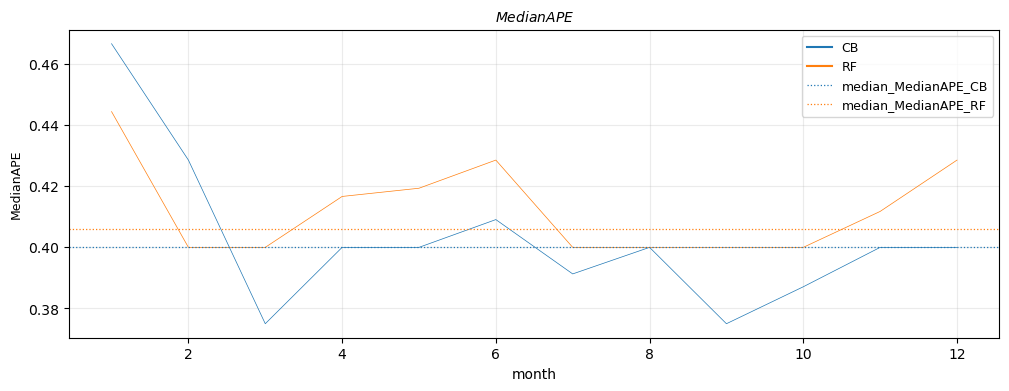

In [65]:
fig = plt.figure(figsize=(12, 4))

sns.lineplot(
            x=medianape_metric['month'],
            y=medianape_metric[metric_name],
            hue=(medianape_metric['model']).astype(str),
            linewidth=0.5
        )

for model, color in zip(['CB', 'RF'], ['tab:blue', 'tab:orange']):
    plt.axhline(
            medianape_metric[medianape_metric['model'] == model][metric_name].median(),
            color=color, label=f'median_{metric_name}_{model}', linestyle='dotted', linewidth=0.9
        )
plt.title(f'${metric_name}$', fontsize=10)
plt.ylabel(f'{metric_name}', fontsize=9)
plt.grid(alpha=0.25)
plt.legend(fontsize=9)

plt.show()

- MedianAPE также примерно на одном уровне у обоих моделей и составляет около 40%

### Total sells

In [66]:
total = all_preds.groupby(['date', 'model'])[[TARGET, PREDICTION]].sum().reset_index().set_index(DATE)

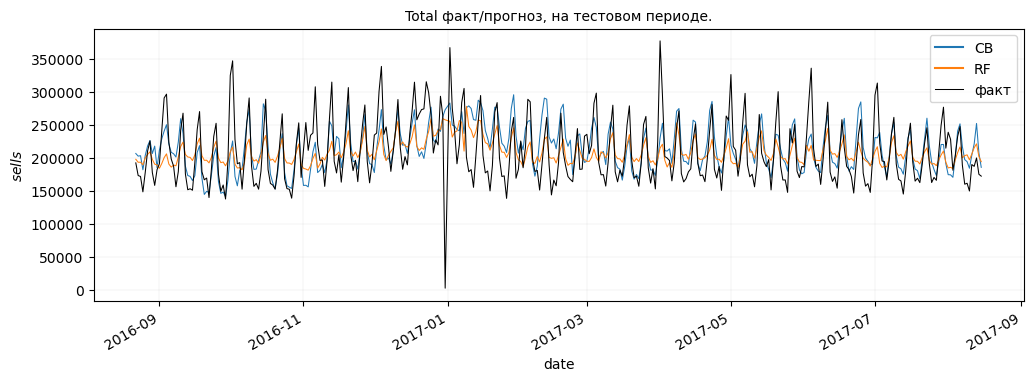

In [68]:
fig = plt.figure(figsize=(12, 4))

sns.lineplot(
        y=total[PREDICTION],
        x=total.index,
        hue=total['model'],
        linewidth=0.75
    )

total[total['model'] == total['model'].unique()[0]][TARGET].plot(color='black', linewidth=0.75, label='факт')

# plt.axvline(test_start_idx, color='r', linestyle='--', label='начало тестового периода', linewidth=0.8)

plt.title(f'Total факт/прогноз, на тестовом периоде.', fontsize=10)
plt.ylabel('$sells$')
plt.legend()
plt.xlabel(DATE)
plt.grid(linewidth=0.1)

- суммарный профиль продаж более точный у catboost
- random forest реже ловит падение прода

### Random units

- посмотри на профили факт/прогноз случайных объектов

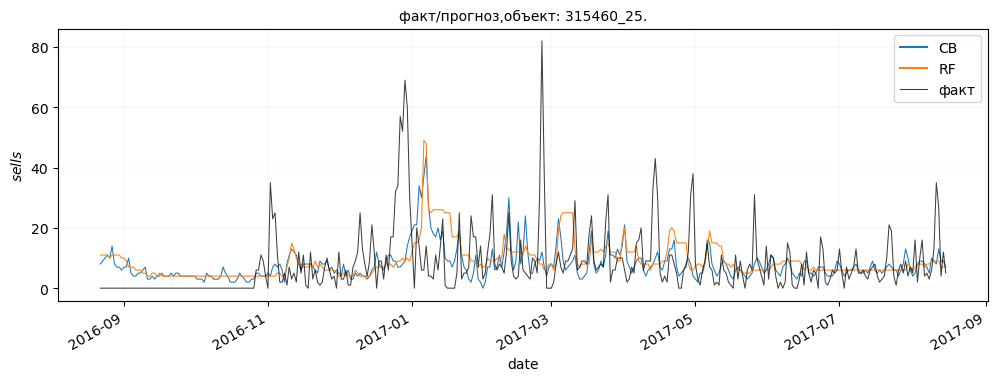

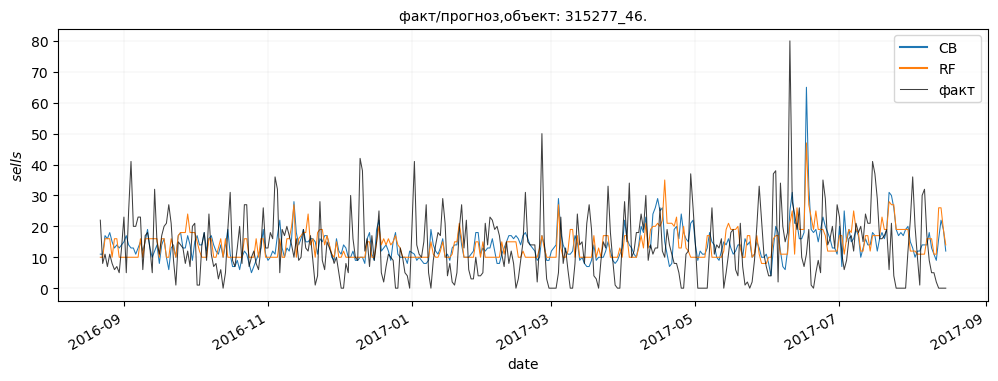

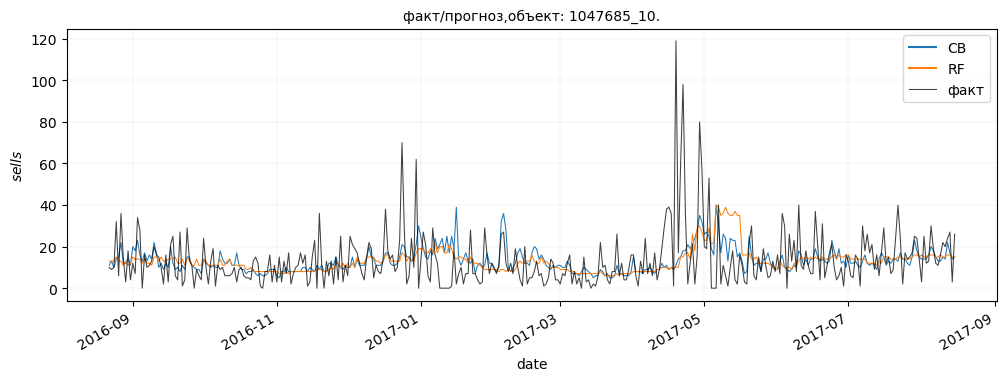

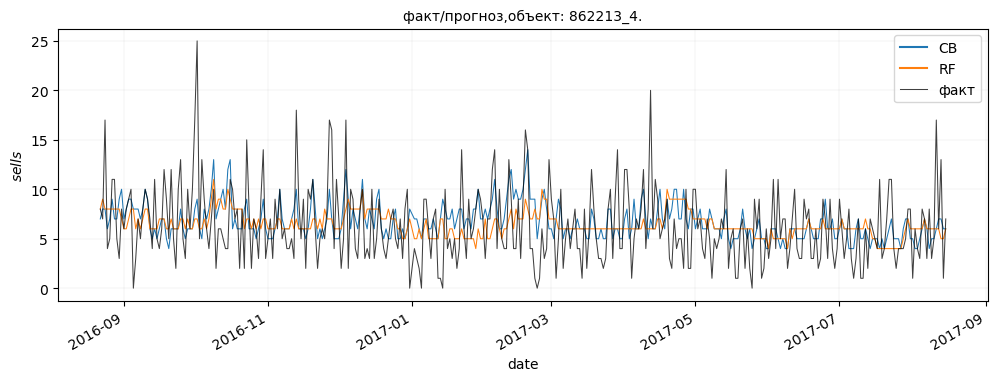

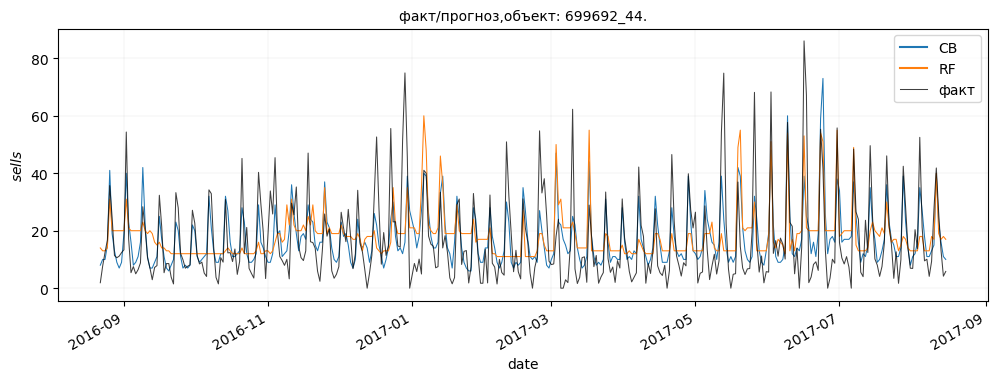

In [70]:
for item in all_preds[PREDICTING_UNIT].drop_duplicates().sample(5):
    tmp = all_preds[all_preds[PREDICTING_UNIT] == item].set_index(DATE)

    fig = plt.figure(figsize=(12, 4))
    
    sns.lineplot(
        y=tmp[PREDICTION],
        x=tmp.index,
        hue=tmp['model'],
        linewidth=0.75
    )

    tmp[tmp['model'] == tmp['model'].unique()[0]][TARGET].plot(color='black', alpha=0.75, linewidth=0.75, label='факт')

    plt.title(f'факт/прогноз,объект: {item}.', fontsize=10)
    plt.ylabel('$sells$')
    plt.legend()
    plt.xlabel(DATE)
    plt.grid(linewidth=0.1)

    plt.show()

- по графикам видно, что catboost быстрее реагиреут на изменение паттернов продаж товаров и лучше ловит сам профиль
- random forest в некоторых случаях, будто, просто протягивает средним значением, чего не встретишь у catboost

## Выводы

Учитывая, что:
1. Мы использовали самые базовые признаки;
2. Не проводили эксперименты с кластеризацией объектов, а сразу взяли дефолтные;
3. Не эксперементировали с таргетом:
    - можно брать логарифм; 
    - делить на среднее n предыдущих точек; 
    - брать изменение продаж вместо абсолютных значений.
4. Обучили модели на дефолтных параметрах.

Мы считаем, что достигли достаточно **хороших** метрик, и опираясь на них и на время, необходимое для обучения моделей (10мин - catboost, 152мин - random forest), мы отдаем предпочтение catboost. Финальные метрики:
- MedianAPE = 0.4
- WAPE = 0.47
- профиль тотал прогнозов точно соответсвует факту
- профили отдельных товаров, за исключением выбросов, также хорошо повторяют фактические значения.

## 3. 6. [Не обязательная часть] Tuning

Попробуйте настроить гиперпараметры бустинга, чтобы добиться лучшего качества.
